# Koneoppimisen perusteet harjoitustyö - Lauri Leppänen

Tehtävässä käytettävä data tulee tiedostosta "train_set_ht.csv". Data sisältää tietoa viinien objektiivisista ominaisuuksista ja asiantuntijoiden antaman pistearvon viinin laadusta.
Tehtävän tavoite on opettaa mahdollisimman tarkka koneoppimismalli, joka osaa arvioida viinin laatua niiden ominaisuuksien perusteella. 

Tehtävässä täytyy opettaa vähintään yksi lineaarinen ja yksi epälineaarinen malli ja vertailla näitä keskenään.

### Johdanto
Aloitetaan hakememalla data tiedostosta ja tarkastelemalla mitä se pitää sisällään: 

In [22]:
import pandas as pd

df = pd.read_csv("../train_set_ht.csv", index_col=0) # Data csv-tiedostossa on indeksoitu. Parametri index_col=0 jätettää indeksit pois dataframesta (df).

print('datan kuvaus muodossa (rivit,sarakkeet): ', df.shape, '\ndatan sarakkeiden nimet: ', df.columns) # data koostuu 30 000 rivistä ja 12 sarakkeesta, sarakkeet ovat: x1,x2...,x10,x11 ja y

print('tyhjät arvot sarakkeiden mukaan:\n', df.isna().sum(), '\n\ntyhjiä arvoja yhteensä: ', df.isna().sum().sum()) # tarkastellaan kuinka paljon tyhjiä arvoja data sisältää.

print('\ny-sarakkeen arvojen lukumäärä: ', df['y'].value_counts()) # y (viinien laatu) sisältää kokonaislukuja 3 - 8 välillä. Huomataan, että viinejä laadulla 3 on äärimmäisen vähän, eikä niitä ole tarpeen ottaa huomioon.


datan kuvaus muodossa (rivit,sarakkeet):  (30000, 12) 
datan sarakkeiden nimet:  Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'y'],
      dtype='object')
tyhjät arvot sarakkeiden mukaan:
 x1     305
x2     301
x3     321
x4     302
x5     319
x6     275
x7     306
x8     309
x9     316
x10    288
x11    297
y      315
dtype: int64 

tyhjiä arvoja yhteensä:  3654

y-sarakkeen arvojen lukumäärä:  y
6.0    12986
5.0     8805
7.0     6472
4.0      829
8.0      590
3.0        3
Name: count, dtype: int64


Huomataan, että data sisältää paljon tyhjiä arvoja, jotka täytyy siistiä ennen mallin opettamista:

Tyhjennetään seuraavaksi kaikki sellaiset rivit, jossa tyhjiä arvoja on yli yksi tai tyhjä arvo on sarakkeessa 'y' (laatu):
Lisäksi poistetaan rivit, joissa 'y' == 3, näiden rivien vähäisyyden takia.

In [23]:
df.dropna(subset=['y'],inplace=True) # poistetaan kaikki rivit, joissa y arvo on tyhjä
df = df[df.y !=3] # poistetaan rivit, joissa viinin laatu on 3.

df.dropna(thresh=11,inplace=True,axis=0) # poistetaan sellaiset rivit, joissa on kaksi tai enemmän tyhjää arvoa.

print('datan kuvaus y-sarakkeen siistimisen jälkeen: \n',df.shape) 
print(df['y'].value_counts())

print('rivien lukumäärä, jossa tyhjiä arvoja on enemmän kuin yksi: ', (df.isna().sum(axis=1) > 1).sum()) # Nyt on enää jäljellä sellaisia rivejä, joissa on ainoastaan yksi tyhjä arvo, joka ei ole sarakkeessa 'y'.
print('tyhjien arvojen lukumäärä: ', df.isna().sum().sum()) # tyhjiä arvoja on silti noin 3000 kappaletta

datan kuvaus y-sarakkeen siistimisen jälkeen: 
 (29535, 12)
y
6.0    12920
5.0     8762
7.0     6442
4.0      825
8.0      586
Name: count, dtype: int64
rivien lukumäärä, jossa tyhjiä arvoja on enemmän kuin yksi:  0
tyhjien arvojen lukumäärä:  2961


### Tyhjien arvojen täydentäminen
Nyt kun jäljellä on enää sellaisia rivejä, joissa tyhjiä arvoja on enintään yksi, eikä se ole laatua kuvaava rivi, voidaan tyhjät arvot täyttää iteroinnin avulla.

Datan skaalaus tapahtuisi tässä vaiheessa, mutta koska mallilla testattava data ei (todennäköisesti) ole skaalattu, ei myöskään opetusdataa kannata skaalata.

In [24]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=25, tol=0.001,random_state=1)
data_imputed = imputer.fit_transform(df) # täydennetään X:n tyhjät arvot

data_imputed = pd.DataFrame(data_imputed, columns=df.columns)

print('tyhjien arvojen lukumäärä: ', data_imputed.isna().sum()) # tarkastetaan onko tyhjiä arvoja vielä jäljellä



tyhjien arvojen lukumäärä:  x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
y      0
dtype: int64


Nyt kun data on esikäsitelty ja valmiina opetettavaksi, voimme visualisoida datan sisältöä:

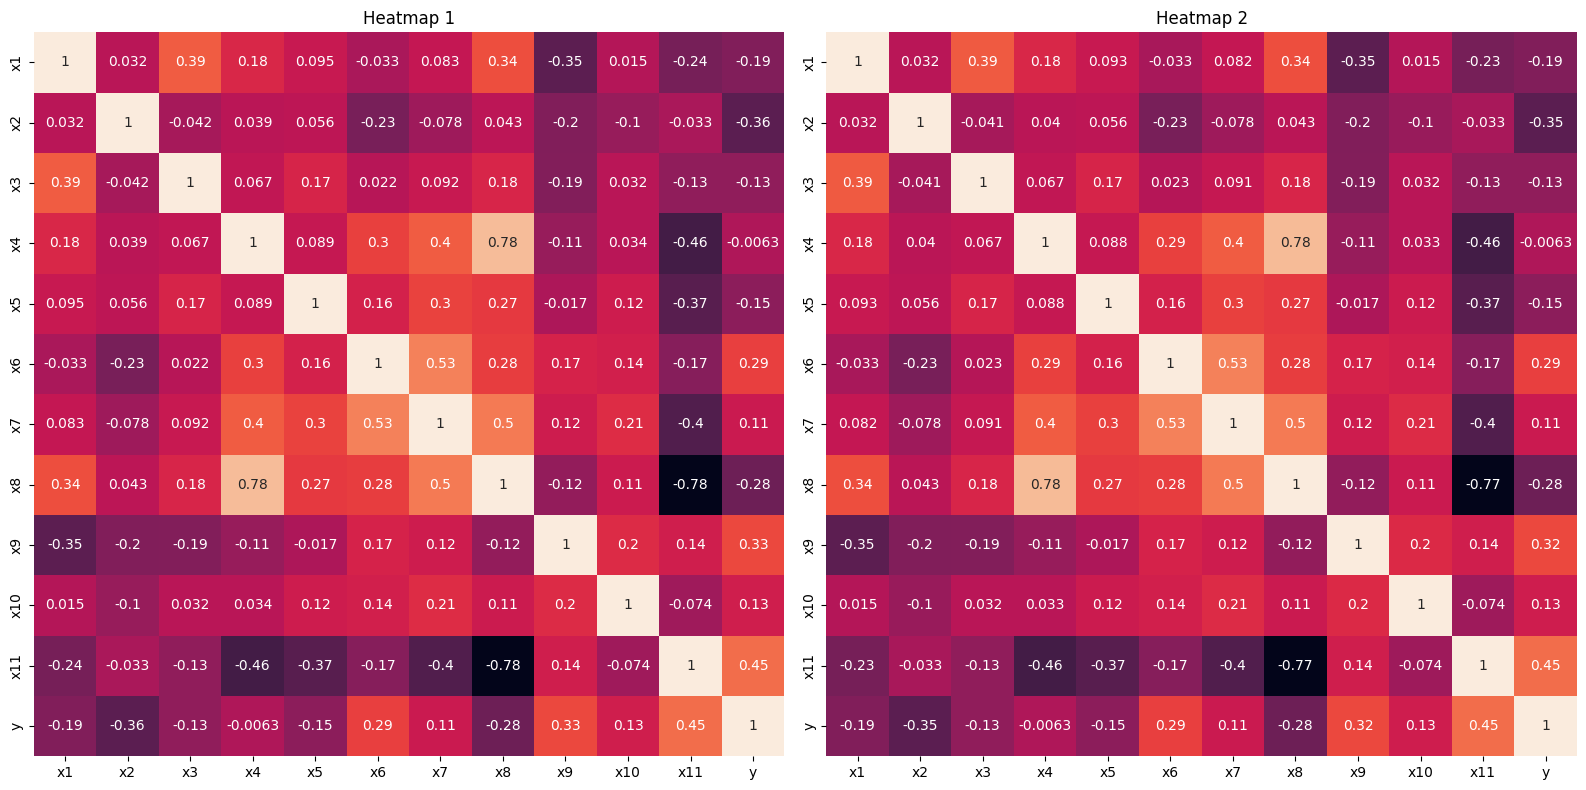

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Korrelaatiomatriiisi imputoidulle datalle
sns.heatmap(data_imputed.corr(method='pearson'), annot=True, cbar=False, ax=axes[0])
axes[0].set_title('Heatmap 1')

# Korrelaasiomatriisi alkuperäiselle datalle
sns.heatmap(df.corr(method='pearson'), annot=True, cbar=False, ax=axes[1])
axes[1].set_title('Heatmap 2')

plt.tight_layout()
plt.show()


Yllä olevissa korrelaatiomatriiseissa on vasemmalla täydennetty data ja oikealla täydentämäton data. Matriiseja vertaillessa huomataan, että ne eivät eroa toisistaan merkittävästi. Matriisista voidaan päätellä, että iterointi ei vaikuttanut arvojen suhteisiin merkittävällä tavalla.

Tässä vaiheessa voisi myös harkita sellaisten datan sarakkeiden pudottamista, joissa korrelaatio on kahden syötemuuttujan välillä korkea (kuten x8 ja x4). En kuitenkaan halua poistaa datasta sarakkeita. 

Luodaan seuraavaksi histogrammi josta näkyy y arvojen määrä datassa:

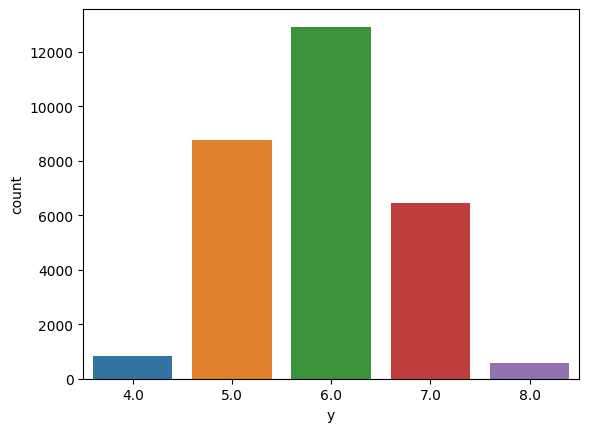

In [26]:
sns.countplot(x=data_imputed['y'])
plt.show() 

Histogrammista huomataan, että suurin osa viineistä kuuluu laatuluokkaan 5,6 tai 7. Hyvin vähän arvoja luokassa 4 ja 8. 

Mallin kouluttamisessa olisi hyvä ottaa huomioon vastemuuttujien arvojen vaihteleva määrä. Dataa voitaisiin esimerkiksi yli- tai alisovittaa, mutta en tee näin tässä tehtävässä.

Visualisoidaan vielä viinin yksittäisten ominaisuuksien suhdetta laatuun tarkemmin.

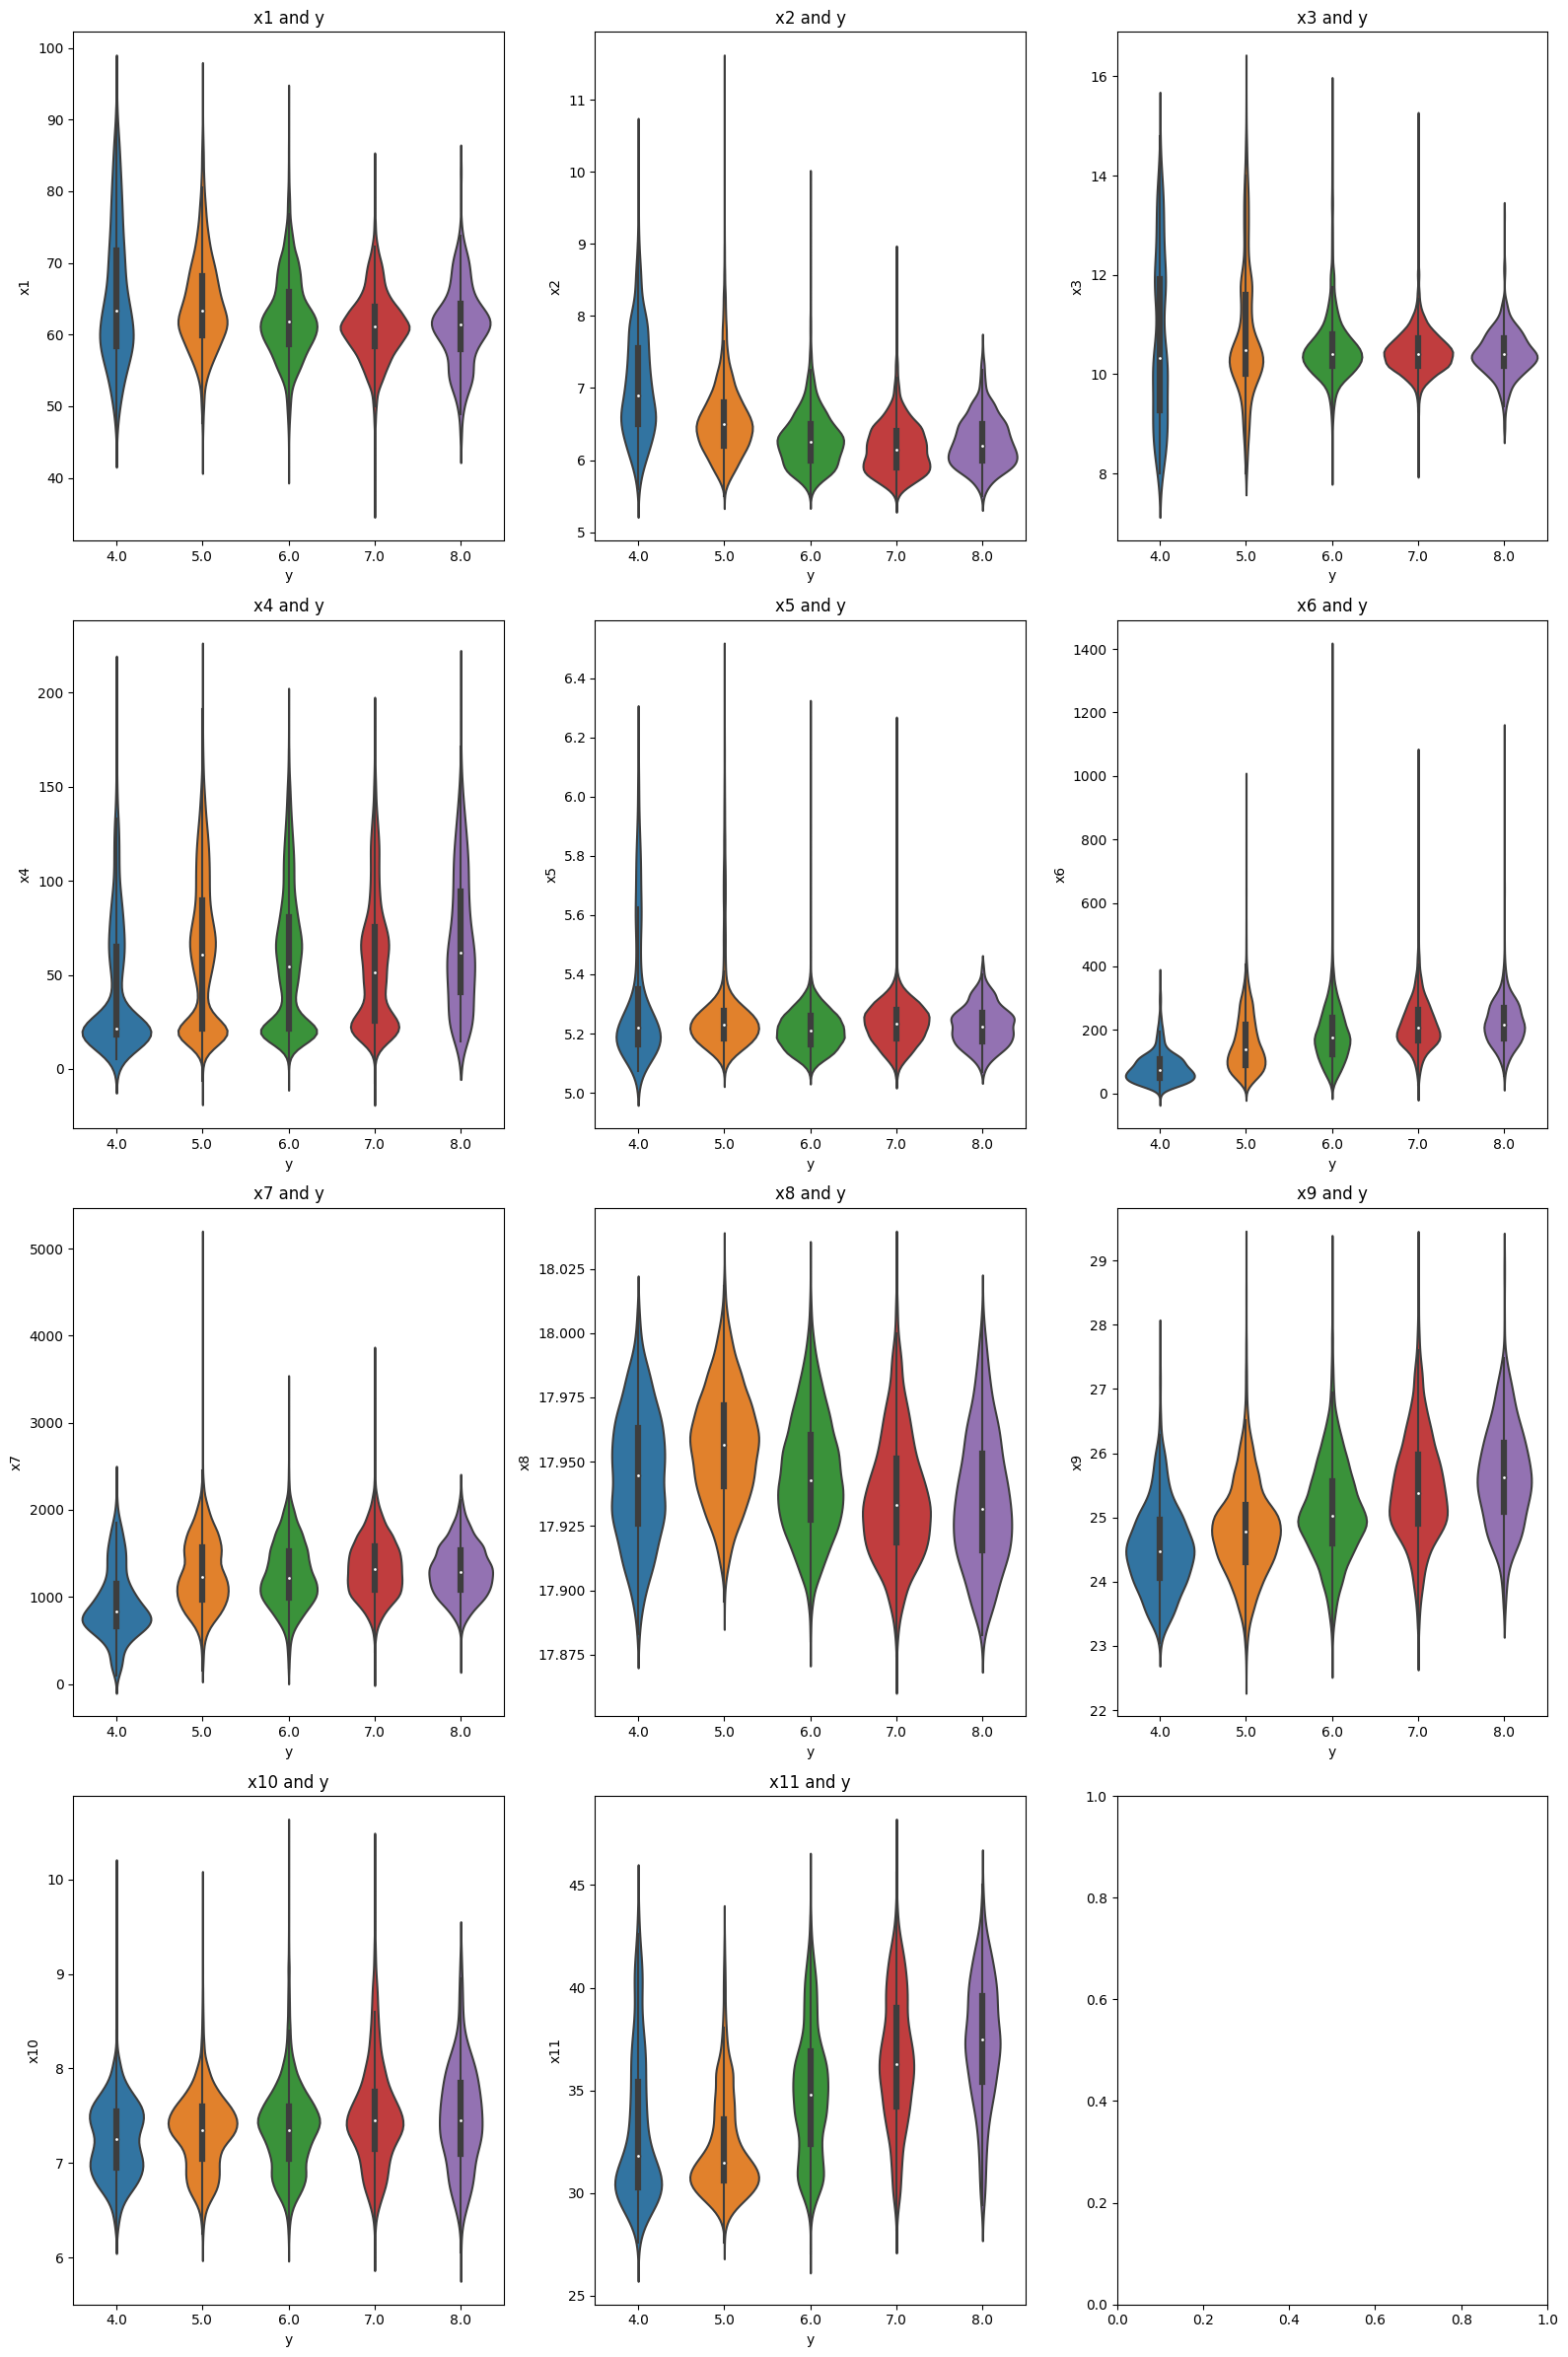

In [27]:
column_names = data_imputed.columns.values.tolist()
column_names.remove('y')

num_rows = 4
num_cols = 3

# Luodaan kaikille syötemuuttujille (x1...-..x11) oma kuvaaja
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 6*num_rows))
for i, var in enumerate(column_names):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    sns.violinplot(y=var, x='y', data=data_imputed, ax=ax)
    ax.set_xlabel('y')
    ax.set_ylabel(var)
    ax.set_title(f'{var} and y')

plt.tight_layout()
plt.show()

Yllä olevia kuvaajia tarkasteltaessa on vaikea erottaa yksittäisiä muuttujia, jotka erottaisivat kaikki y:n arvot selkeästi toisistaan.
Jos kiinnitetään huomiota vain eniten esiintyviin y:n arvoihin (5, 6 ja 7), on silmämääräisesti hyvin vaikea erottaa datasta selkeitä toisiaan erottelevia tekijöitä. 
Selkeimmät selittävät tekijät kuvaajien perusteella ovat x11, x9, x8. On hyvä pitää mielessä, että arvojen vaihteluväli on suuri, joten erinomaisen tarkkaa mallia on todennäköisesti mahdotonta toteuttaa.

### Mallien opetus

Aloitetaan mallien opetus: jaetaan aikaisemmin täydennetty data opetus- ja testidataksi.

In [28]:
from sklearn.model_selection import train_test_split

# Otetaan syöte- ja vastemuuttujat erilleen
y=data_imputed['y']
X=data_imputed.drop('y',axis=1)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.02, random_state=42)

print("Opetusdata: ",X_train.shape, y_train.shape, "Testidata: ",X_test.shape,y_test.shape)

(29535, 11) (29535,)
Opetusdata:  (28944, 11) (28944,) Testidata:  (591, 11) (591,)


Opetetaan ensin lineaarinen malli:

Käytetään parametrien optimointiin gridsearchcv:tä.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import time
import warnings
warnings.filterwarnings('ignore')


param_grid = {'solver':['lbfgs','saga','sag','newton-cg'],
              'C':[1.0,0.1,0.01],
              'class_weight' :[None,'balanced']
              }

start_time = time.time()


clf = LogisticRegression(random_state=123,max_iter=1200)

LR_grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
LR_grid_search.fit(X_train, y_train)

best_result = LR_grid_search.best_estimator_
best_params = LR_grid_search.best_params_
print(best_result, 'params: ' ,best_params )
LR_y_pred = LR_grid_search.predict(X_test)

print(classification_report(y_test, LR_y_pred)) # Tulostetaan luokitteluraportti. Tämä kertoo kuinka hyvin eri luokkat onnistuivat tunnistamaan testiaineistosta oikeita tuloksia. 

end_time = time.time()-start_time
print('Opetukseen käytetty aika {:.2f}'.format(end_time))

from joblib import dump, load

dump(LR_grid_search.best_estimator_,'testingLR.joblib')


Fitting 5 folds for each of 24 candidates, totalling 120 fits
LogisticRegression(max_iter=1200, random_state=123, solver='newton-cg') params:  {'C': 1.0, 'class_weight': None, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00        14
         5.0       0.71      0.71      0.71       170
         6.0       0.64      0.75      0.69       269
         7.0       0.59      0.48      0.53       128
         8.0       0.00      0.00      0.00        10

    accuracy                           0.65       591
   macro avg       0.39      0.39      0.38       591
weighted avg       0.62      0.65      0.63       591

Opetukseen käytetty aika 1777.66


['testingLR.joblib']

Koulutettu logistinen regressiomalli antaa testidatalla kohtalaisen painotetun tarkkuuden (0.63), mutta makrotason tarkkuus ei ole kovin hyvä (0.38).
 
Kokeillaan saadaanko parempi malli satunnaismetsän avulla:

Etsitään taas parhaat parametrit gridsearchCV:n avulla

In [30]:
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'max_depth': [10,20,30],
    'class_weight':['balanced',None],
    'n_estimators': [100,200,300],
    'min_samples_split':[4,5,6],
    'max_features': ['sqrt', 'log2'],
}

start_time_ = time.time()
tree = RandomForestClassifier(random_state=42)

RFC_grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
RFC_grid_search.fit(X_train, y_train)

best_forest = RFC_grid_search.best_estimator_
best_params = RFC_grid_search.best_params_
best_score = RFC_grid_search.best_score_

RFC_y_pred = RFC_grid_search.predict(X_test)
print(best_forest, best_params)
print('score: ', best_score)
print(classification_report(y_test,RFC_y_pred) )# Tulostetaan luokitteluraportti. Tämä kertoo kuinka hyvin eri luokkat onnistuivat tunnistamaan testiaineistosta oikeita tuloksia. 

end_time_ = time.time()-start_time_
print('Opetukseen käytetty aika: {:.2f}'.format(end_time_))

#dump(RFC_grid_search.best_estimator_,'testingRFC.joblib')



Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=300,
                       random_state=42) {'class_weight': None, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
score:  0.6760989045425261
              precision    recall  f1-score   support

         4.0       0.50      0.07      0.12        14
         5.0       0.74      0.76      0.75       170
         6.0       0.69      0.78      0.73       269
         7.0       0.69      0.60      0.64       128
         8.0       0.00      0.00      0.00        10

    accuracy                           0.70       591
   macro avg       0.52      0.44      0.45       591
weighted avg       0.69      0.70      0.69       591

Opetukseen käytetty aika: 746.11


Satunnaismetsä saa painotetuksi tarkkuudeksi (0.69) ja makrotarkkuudeksi (0.45). Tämä tulos on logistista regressiomallia parempi.

Tarkastellaan vielä mitkä ominaisuudet olivat mallien mielestä kaikista merkityksellisiä mallin opetuksessa:

[0.06872829 0.09279743 0.08825263 0.08623583 0.07803609 0.12168998
 0.0835818  0.09736121 0.07056905 0.06057215 0.15217555]


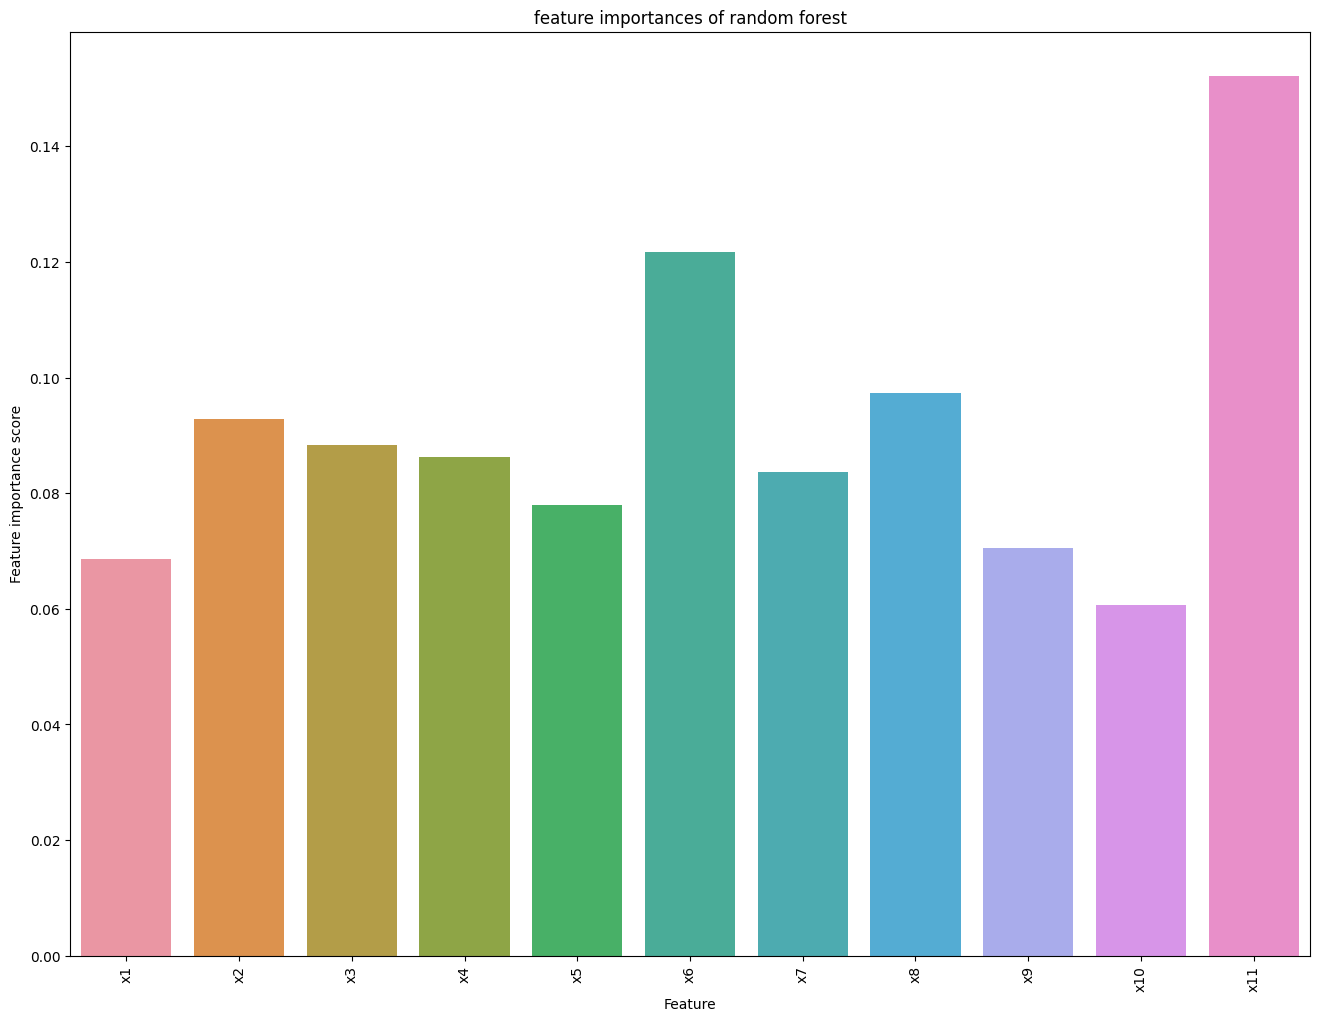

[6.24330962e-03 1.43220768e+00 2.16425951e-01 1.64819404e-02
 2.00989106e+00 7.32015841e-03 9.77196217e-04 3.84893248e+00
 4.32564155e-01 3.12009288e-01 4.14261593e-01]


<Axes: ylabel='Feature'>

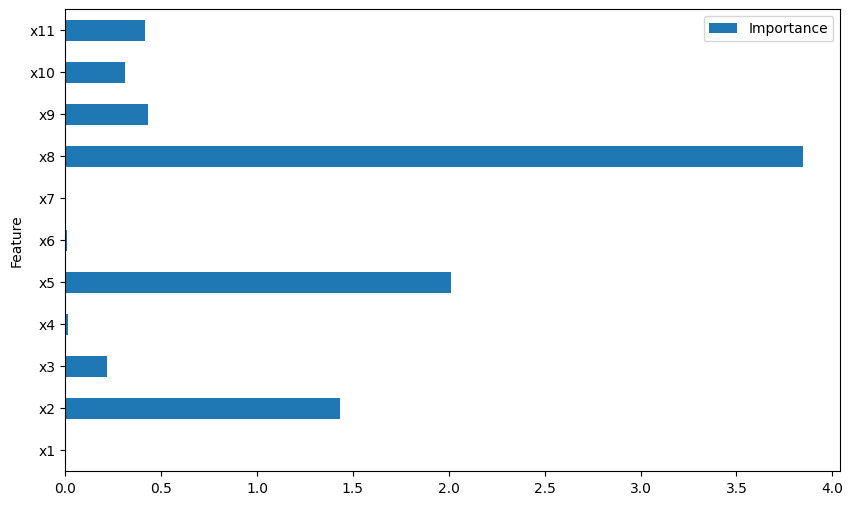

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
forest = load('testingRFC.joblib')
print(forest.feature_importances_)


feature_scores = pd.Series(forest.feature_importances_, index=column_names)
feature_scores = feature_scores.round(4)


f, ax = plt.subplots(figsize=(16, 12))
ax = sns.barplot(x=feature_scores.index, y=feature_scores)
ax.set_title("feature importances of random forest")
ax.set_xticklabels(feature_scores.index,rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Feature importance score")
plt.show()


logistic_model = load('testingLR.joblib')

importancesLR = np.abs(logistic_model.coef_).mean(axis=0)

print(importancesLR)

feature_importanceLR = pd.DataFrame({'Feature': column_names, 'Importance': importancesLR})
feature_importanceLR.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Huomataan, että satunnaismetsä pitää jokaista arvoa jossain määrin tärkeänä, kun taas logistinen regressiomalli pitää tärkeänä vain osaa ominaisuuksista. Omituista on, että satunnaismetsä pitää ominaisuutta 'x11' erityisen tärkeänä, kun taas logistinen regressio ei anna tälle ominaisuudelle suurta painoarvoa.

In [32]:
from sklearn.metrics import accuracy_score

print(accuracy_score(LR_y_pred, y_test))
print(accuracy_score(RFC_y_pred, y_test))

0.6463620981387479
0.7038917089678511


### Yhteenveto
Satunnaismetsän malli on testidatalla tarkempi. Aikaisemmin tulostettuja luokitteluraportteja tarkasteltaessa huomataan, että kumpikaan malleista ei onnistunut luokittelemaan yhtäkään luokkaan 8 kuuluneista viineistä oikein. Huomionarvoista on, että molemmat mallit saivat paremman tarkkuuden, kun painotus (class_weight) oli sivuutettu. Tasapuolisen painotuksen avulla pienempiä luokkia olisi varmasti onnistuttu tunnistamaan paremmin, mutta tällöin yleisempien luokkien tarkkuus olisi huonontunut. Huomasimme jo datan visualisoinnin aikana, että suurimmalla osalla viinien ominaisuuksista ei ole selkeää korrelaatiota laadun kanssa, jonka takia hyvin tarkkaa luokittelua ei onnistuttu saavuttamaan. 

Satunnaismetsän malli kuitenkin onnistuu luokittelemaan laadut 5, 6 ja 7 kohtalaisen tarkasti tehtävän vaativuuteen suhteutettuna.

Tallennetaan opetettu satunnaismetsän malli tiedostoon "lepplaju.joblib" :

In [39]:
model_to_save = RFC_grid_search.best_estimator_

#print(model_to_save.estimators_)
dump(model_to_save,'lepplaju.joblib', compress=3)

['lepplaju.joblib']

Tehdään vielä lopuksi koodi, joka hakee tallennetun mallin tiedostosta ja ennustaa viinien laatua tuntemattomalla datalla:

Koko gridSearchCV:n tuottama tulos on tallennettuna tiedostoon, joten sieltä täytyy erikseen poimia paras satunnaismetsä käyttöön.

In [40]:
model_to_use = load('lepplaju.joblib')

# test_dataX = pd.read_csv("test_set.csv")
# pred_y = model_to_use.predict(test_dataX)